# Pairs Trading Strategy

In this notebook I've implemented a Pairs Trading Strategy. Pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement.

In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(100) # just set the seed for the random number generator

import matplotlib.pyplot as plt

## How to find correlated securities?

The best way to do this is to start with securities we suspect may be cointegrated (may be economically linked) and perform a statistical test. If we just run statistical tests over all pairs, we’ll fall prey to **multiple comparison bias**.

We'll work with a basket of US large cap tech stocks — in S&P 500. These stocks operate in a similar segment and **could** have cointegrated prices. We scan through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05. 

**Note:** This method as mentioned above is prone to multiple comparison bias and ideally we should do some sort of a second verification step.


In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2) # To check for co-integration
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

#startDateStr = '2007/12/01'
#endDateStr = '2017/12/01'
#startDateStr = '2010/12/01'
startDateStr = '2010/12/01'
endDateStr = '2020/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM'] # Big Tech Companies we suspect to be co-integrated
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


In [4]:
data.head(3)

,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2010-12-01,98.650627,9.747958,28.370001,11.959637,20.703621,36.314503,14.562396,30.117580,7.51,102.408737
2010-12-02,99.914200,9.801870,29.100000,12.225314,21.379427,36.769489,14.747127,30.238604,7.54,102.954765
2010-12-03,100.183258,9.779997,29.139999,12.102694,21.482788,37.019711,14.719764,29.668066,7.65,103.096619


Lets  run our method on the list and see if any pairs are cointegrated.

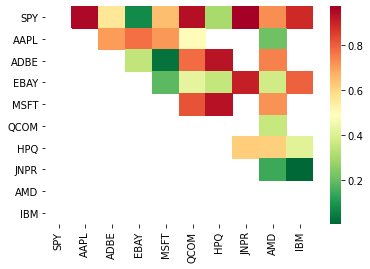

[('ADBE', 'MSFT'), ('JNPR', 'IBM')]


In [5]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)

Looks like 'ADBE' and 'MSFT' are cointegrated. Let's take a look at the ratio.

pValue = 0.026390940781562004


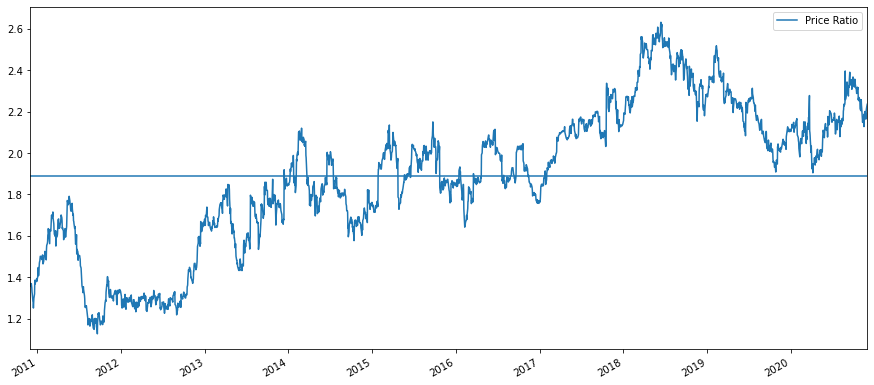

In [6]:
S1 = data['ADBE']
S2 = data['MSFT']
#S1 = data['JNPR']
#S2 = data['IBM']
score, pvalue, _ = coint(S1, S2)
print("pValue = "+str(pvalue))
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

The ratio does look like it moved around a stable mean. It is more helpful to normalize our signal by treating it as a z-score. Z score is defined as:

<i>Z Score (Value) = (Value — Mean) / Standard Deviation </i>

<b>CAVEAT</b>
In practice this is usually done to try to give some scale to the data, but this assumes an underlying distribution. Usually normal. However, much financial data is not normally distributed, and we must be very careful not to simply assume normality, or any specific distribution when generating statistics. The true distribution of ratios could be very fat-tailed and prone to extreme values messing up our model and resulting in large losses.

In [7]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

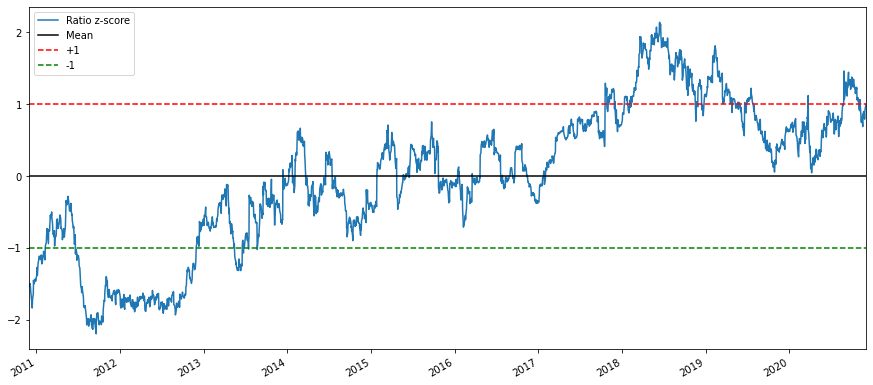

In [8]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

## Trading Strategy:

We'll keep it simple:
* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

Instead of using simple ratio values, let's use 5d Moving Average to compute to z score, and the 60d Moving Average and 60d Standard Deviation as the mean and standard deviation.

First break the data into training set of 8 years and test set of 2 years

In [9]:
#ratios = data['ADBE'] / data['MSFT']
#print(len(ratios))
train = ratios[:2024]
test = ratios[2024:]

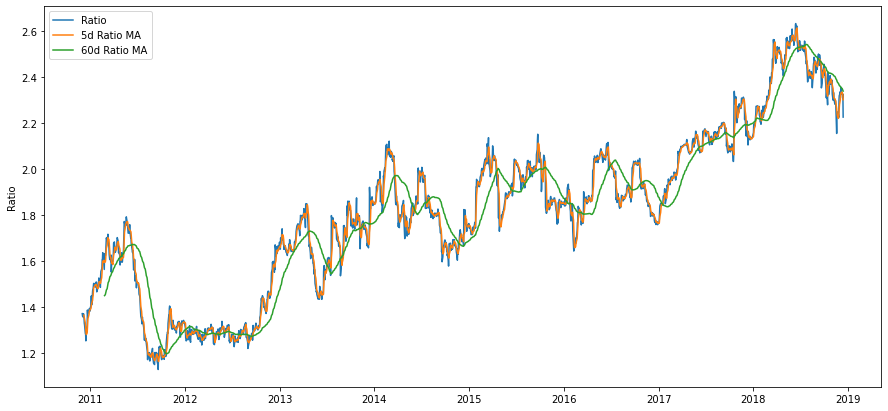

In [10]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std() 

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60 
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

## We see that the Rolling Ratio varies around the Mean

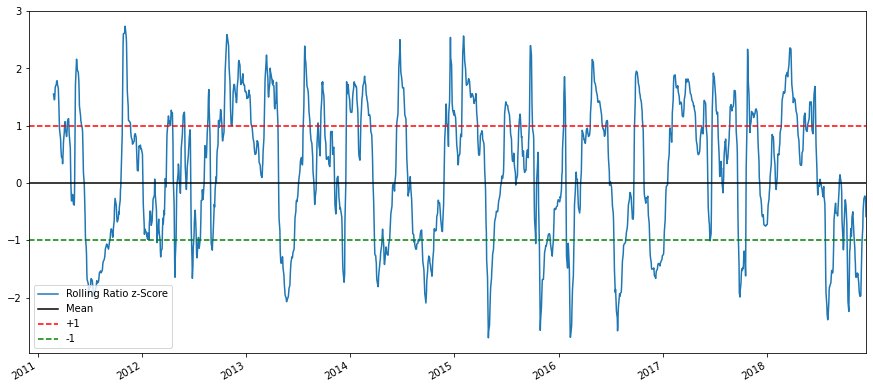

In [11]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

## Visualizing Buy/Sell based on our Trading Strategy on the Training set

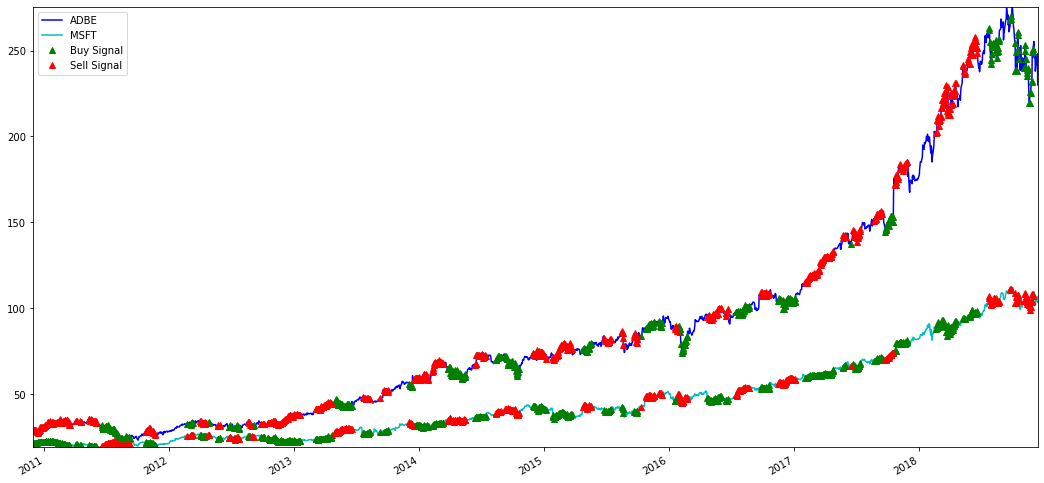

In [12]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:2024]
S2 = data['MSFT'].iloc[:2024]

buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

S1.plot(color='b')
S2.plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR.plot(color='g', linestyle='None', marker='^')
sellR.plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()


## Finally let's Trade!

I write a simple backtester which buys 1 ratio (buy 1 ADBE stock and sell ratio x MSFT stock) when ratio is low, sell 1 ratio (sell 1 ADBE stock and buy ratio x MSFT stock) when it’s high and calculate PnL of these trades.

In [13]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['ADBE'].iloc[:2024], data['MSFT'].iloc[:2024], 5, 176)


3476.230138641906

The strategy seems profitable!

Let's see how it does on test data

In [14]:
trade(data['ADBE'].iloc[2024:], data['MSFT'].iloc[2024:], 5, 176)

3248.218367922713

# We're making some be money!

## Let's get the best window size based on our Validation set.

In [17]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ADBE'].iloc[:2024], 
                data['MSFT'].iloc[:2024], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 195


In [18]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[2024:], 
                  data['MSFT'].iloc[2024:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

195 day window: 3146.071037360193
176 day window: 3248.218367922713


## To avoid overfitting we have choosed the best window size using the Validation set

**Note:** Ideally we should also have a separate test set to evaluate our final performance with the selected window size.

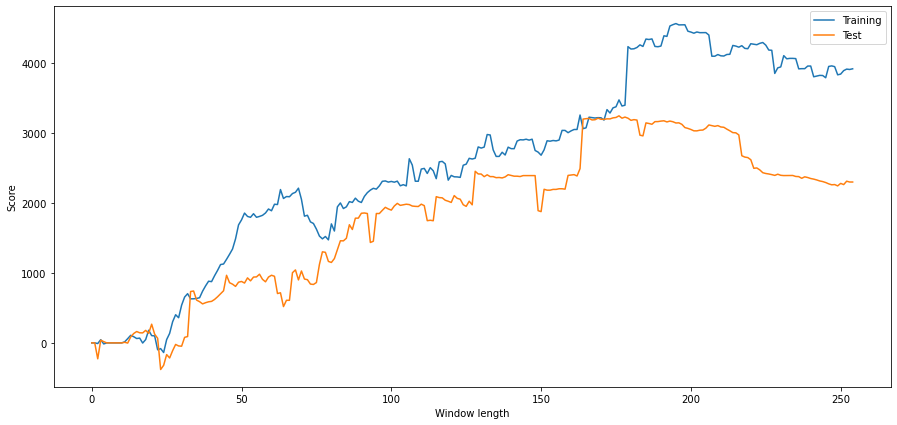

In [19]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()